# [**Sélection du modèle avec PCA probabiliste et analyse factorielle (FA)**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/2_5_decomposition/plot_pca_vs_fa_model_selection.ipynb)<br/>([*Model selection with Probabilistic PCA and Factor Analysis (FA)*](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html))

L'ACP probabiliste et l'analyse factorielle sont des modèles probabilistes. La conséquence est que la probabilité de nouvelles données peut être utilisée pour la sélection du modèle et l'estimation de la covariance. Ici, nous comparons PCA et FA avec une validation croisée sur des données de rang inférieur corrompues par un bruit homoscédastique (la variance du bruit est la même pour chaque caractéristique) ou un bruit hétéroscédastique (la variance du bruit est différente pour chaque caractéristique). Dans une deuxième étape, nous comparons la vraisemblance du modèle aux vraisemblances obtenues à partir des estimateurs de covariance de retrait.

On peut observer qu'avec un bruit homoscédastique, FA et PCA réussissent à récupérer la taille du sous-espace de rang inférieur. La probabilité avec PCA est plus élevée que FA dans ce cas. Cependant, l'ACP échoue et surestime le rang lorsque le bruit hétéroscédastique est présent. Dans des circonstances appropriées (choix du nombre de composants), les données retenues sont plus probables pour les modèles de rang inférieur que pour les modèles de retrait.

L'estimation automatique à partir du choix automatique de la dimensionnalité pour PCA. NIPS 2000 : 598-604 de Thomas P. Minka est également comparé.

In [ ]:
# Authors: Alexandre Gramfort
#          Denis A. Engemann
# License: BSD 3 clause

# Création du jeu de données

In [1]:
import numpy as np

from scipy import linalg

n_samples, n_features, rank = 500, 25, 5
sigma = 1.0
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.0
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# Ajustement des modèles

best n_components by PCA CV = 5
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 5
best n_components by PCA CV = 20
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 18


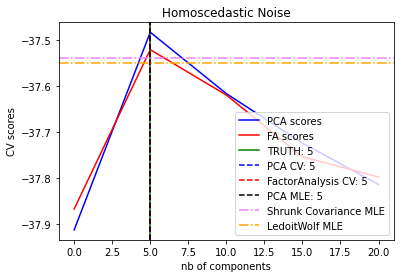

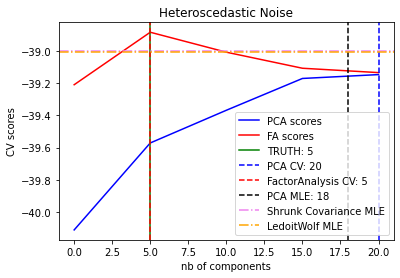

In [2]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


for X, title in [(X_homo, "Homoscedastic Noise"), (X_hetero, "Heteroscedastic Noise")]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver="full", n_components="mle")
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, "b", label="PCA scores")
    plt.plot(n_components, fa_scores, "r", label="FA scores")
    plt.axvline(rank, color="g", label="TRUTH: %d" % rank, linestyle="-")
    plt.axvline(
        n_components_pca,
        color="b",
        label="PCA CV: %d" % n_components_pca,
        linestyle="--",
    )
    plt.axvline(
        n_components_fa,
        color="r",
        label="FactorAnalysis CV: %d" % n_components_fa,
        linestyle="--",
    )
    plt.axvline(
        n_components_pca_mle,
        color="k",
        label="PCA MLE: %d" % n_components_pca_mle,
        linestyle="--",
    )

    # compare with other covariance estimators
    plt.axhline(
        shrunk_cov_score(X),
        color="violet",
        label="Shrunk Covariance MLE",
        linestyle="-.",
    )
    plt.axhline(
        lw_score(X),
        color="orange",
        label="LedoitWolf MLE" % n_components_pca_mle,
        linestyle="-.",
    )

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc="lower right")
    plt.title(title)

plt.show()